##### Quantum Computing 2025/2026
### Lecture 4 - Grover's Algorithm


1. [Grover's Algorithm](#Grover) <p>
   a.  [Unstructured search](#unstructured-search) <p>
   b.  [Oracle](#oracle_intro) <p>
   c.  [Amplitude Amplification](#amplitude_amp) <p>
2. [Grover's algorithm generalization](#grover_general)
3. [Remove the ancilla](#ancilla)

## 1. Grover's algorithm <a id="grover"></a>

Grover's algorithm is one of the most powerful quantum algorithms. The algorithm is known for a quadratic speed up in searching for an element in an **unstructured database**. 

Grover's algorithm can be used in any problem that can be restated as an unstructured search problem:

* Finding minimum/maximum/mean 
* Collision problem 
* Satisfiability 
* Optimization in general. 

### a. Unstructured Search <a id="unstructured-search"></a>

Suppose you have an array of $N$ items. Consider that $w$ for winner is the element we want to find. 

![image1](images/list.png)

Classic $\quad \Rightarrow \quad \mathcal{O}(N)$

Quantum $\quad \Rightarrow \quad \mathcal{O}(\sqrt{N})$

### b. Oracle

Notice that we want to exploit the superposition principle, therefore, all entries in the above database will happen at the same time! Thus, for us, the database is composed by all computational basis states our qubits can be in.

The oracle $U_w$ adds a negative phase to the solution states i.e. for any state $|x\rangle$ in the computational basis corresponding to the winner:

$$
U_\omega|x\rangle = \bigg\{
\begin{aligned}
\phantom{-}|x\rangle \quad \text{if} \; x \neq \omega \\
-|x\rangle \quad \text{if} \; x = \omega \\
\end{aligned}
$$

we can use an ancilla to store the result of the function! 


Similar to Deutsch-Jozsa, we initialize the 'output' qubit in the state $|{-}\rangle$, and the phase kickback effect do the rest.
</p><p>  

![image1](images/function.png)


Now, the goal is to find a routine that amplifies the probability of measuring the winner state! 

### c. Amplitude Amplification <a id="amplitude_amp"></a>

The Diffusion operator $D$ is a reflection about the mean of the amplitudes. It is defined as:

$$D = 2|DB \rangle \langle DB| - I$$

where |DB\rangle is the database superposition quantum state. D amplifies the amplitude of the winner state.

Full Grover's circuit is:
![image5](images/full_circuit.png)

## 2. Grover's algorithm generalization <a id="grover_generalization"></a>

In [29]:
import pennylane as qml
from pennylane import numpy as np

def grover(input_registers, ancilla_register, id, n_iterations):

    #superposition
    for i in input_registers:
        qml.Hadamard(wires=i)

    qml.PauliX(wires=ancilla_register)
    qml.Hadamard(wires=ancilla_register)

    qml.Barrier()

    for n_it in range(n_iterations):
        #oracle
        for i,k in enumerate(id):
            if k == 0:
                qml.PauliX(wires=input_registers[i])
        #qml.MultiControlledX(wires=input_registers + ancilla_register)
        qml.ctrl(qml.PauliX , control=input_registers)(wires=ancilla_register[0])
        for i,k in enumerate(id):
            if k == 0:
                qml.PauliX(wires=input_registers[i])

        #or using the MultiControlledX gate with control state
        #qml.MultiControlledX(control_wires=input_registers, wires=ancilla_register, control_values=id)

        qml.Barrier()
        
        #diffusion
        for i in input_registers:
            qml.Hadamard(wires=i)
            qml.PauliX(wires=i)
        qml.Hadamard(wires=input_registers[-1])
        qml.ctrl(qml.PauliX , control=input_registers[:-1])(wires=input_registers[-1])
        qml.Hadamard(wires=input_registers[-1])
        qml.Barrier(wires=input_registers[0])
        # Dummy operation to maintain structure
        for i in input_registers:
            qml.PauliX(wires=i)
            qml.Hadamard(wires=i)

        qml.Barrier()
    

    #measurement
    return qml.probs(wires=input_registers)

(<Figure size 1800x400 with 1 Axes>, <Axes: >)

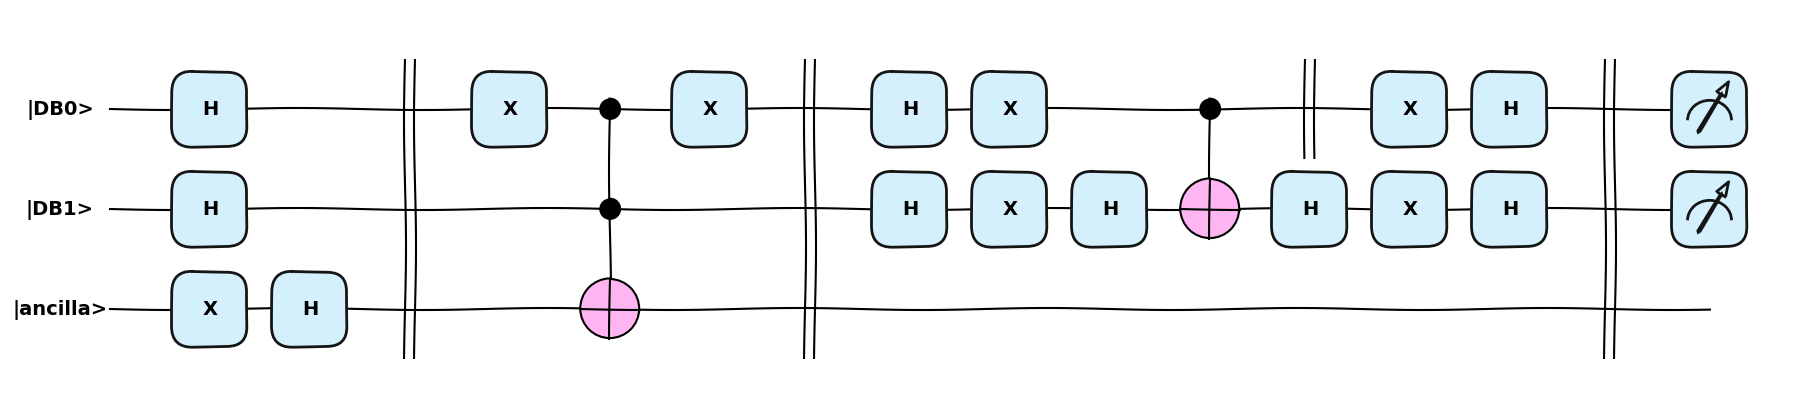

In [30]:
n_qubits = 2
id = [0,1]

input_registers = ["|DB"+str(i)+">" for i in range(n_qubits)]
ancilla_register = ["|ancilla>"] 

n_it = 1

dev = qml.device("default.qubit", wires=input_registers + ancilla_register)

Grover = qml.QNode(grover, dev)

qml.draw_mpl(Grover,style="pennylane_sketch")(input_registers, ancilla_register, id, n_it)

Text(0.5, 1.0, 'Probability Distribution')

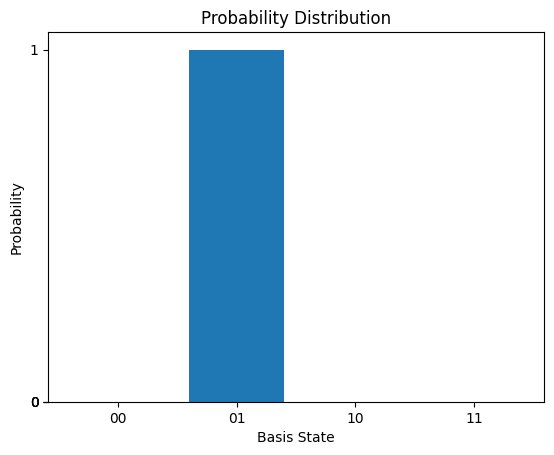

In [31]:
#Run the algorithm

probs = Grover(input_registers, ancilla_register, id, n_it)

#Visualize the probability histogram
import matplotlib.pyplot as plt
plt.bar([np.binary_repr(i, width=n_qubits) for i in range(2**n_qubits)], probs)
plt.xlabel("Basis State")
plt.ylabel("Probability")
plt.yticks(probs)
plt.title("Probability Distribution")



### 3. Remove the ancilla <a id="ancilla"></a>

In [32]:
import pennylane as qml
from pennylane import numpy as np

def grover(input_registers, id, n_iterations):

    #superposition
    for i in input_registers:
        qml.Hadamard(wires=i)

    qml.Barrier()

    for n_it in range(n_iterations):
        #oracle
        for i,k in enumerate(id):
            if k == 0:
                qml.PauliX(wires=input_registers[i])
        #qml.MultiControlledX(wires=input_registers + ancilla_register)
        qml.ctrl(qml.PauliZ , control=input_registers[:-1])(wires=input_registers[-1])
        for i,k in enumerate(id):
            if k == 0:
                qml.PauliX(wires=input_registers[i])

        #or using the MultiControlledX gate with control state
        #qml.MultiControlledX(control_wires=input_registers, wires=ancilla_register, control_values=id)

        qml.Barrier()
        
        #diffusion
        for i in input_registers:
            qml.Hadamard(wires=i)
            qml.PauliX(wires=i)
        qml.Hadamard(wires=input_registers[-1])
        qml.ctrl(qml.PauliX , control=input_registers[:-1])(wires=input_registers[-1])
        qml.Hadamard(wires=input_registers[-1])
        qml.Barrier(wires=input_registers[0])
        # Dummy operation to maintain structure
        for i in input_registers:
            qml.PauliX(wires=i)
            qml.Hadamard(wires=i)

        qml.Barrier()
    

    #measurement
    return qml.probs(wires=input_registers)

(<Figure size 1700x300 with 1 Axes>, <Axes: >)

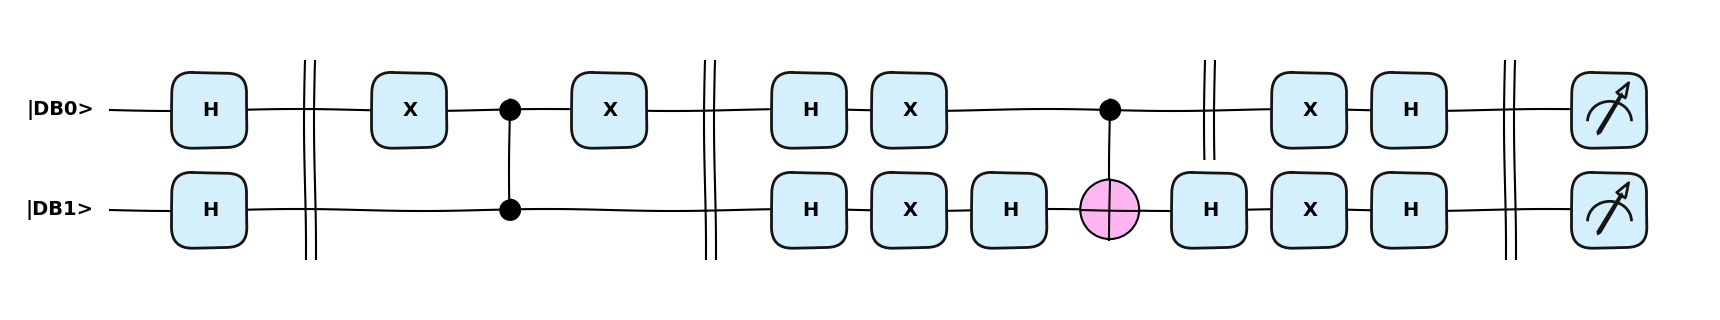

In [33]:
n_qubits = 2
id = [0,1]

input_registers = ["|DB"+str(i)+">" for i in range(n_qubits)]

n_it = 1

dev = qml.device("default.qubit", wires=input_registers)

Grover = qml.QNode(grover, dev)

qml.draw_mpl(Grover,style="pennylane_sketch")(input_registers, id, n_it)

Text(0.5, 1.0, 'Probability Distribution')

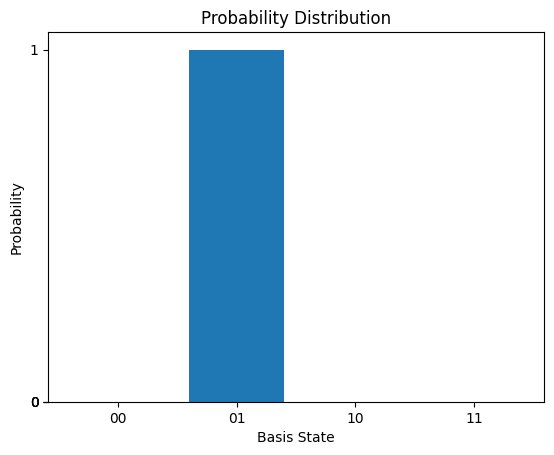

In [34]:
#Run the algorithm

probs = Grover(input_registers, id, n_it)

#Visualize the probability histogram
import matplotlib.pyplot as plt
plt.bar([np.binary_repr(i, width=n_qubits) for i in range(2**n_qubits)], probs)
plt.xlabel("Basis State")
plt.ylabel("Probability")
plt.yticks(probs)
plt.title("Probability Distribution")

